In [51]:
from pygraylog.graylogapi import GraylogAPI
import json
import sys
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime

# GrayLog

In [33]:
from pygraylog.graylogapi import GraylogAPI
import json
import sys
import numpy as np
import pandas as pd
import datetime

In [27]:
log_level = 0

graylog_con={
        "user":"pavel",
        "password":"O777ver7k1",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":1,
        "limit":100
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()
        
fields=[
    'm3ua_OPC','m3ua_DPC',
    'sccp_calling_nai','sccp_calling_digits','sccp_calling_ri','sccp_calling_ssn',
    'sccp_called_nai','sccp_called_digits','sccp_called_ri','sccp_called_ssn',
    'sccp_class','sccp_message_type','protocol_name','protocol','protocol_version','opCode_localValue','TCAP_type',
    'tcap_otid','tcap_dtid',
    'e164_msisdn','e212_imsi']

In [18]:
#Load data from GrayLog

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)

        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)
        return outputResult
    
#Load data into df

def LoadGraylogResultToDataFrame(data):
    columns=list(data[0].keys())
    values = list(data[0].values())
    arr_len = len(values)
    df=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
    for i in range(len(data)-1):
        columns=list(data[i+1].keys())
        values = list(data[i+1].values())
        arr_len = len(values)
        df1=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
        df=pd.concat([df, df1],axis=0,join='outer')
    df=df.reset_index(drop=True)
    if 'tcap_otid' in df.columns:
        df['tcap_otid']=df['tcap_otid'].fillna(0)
    if 'tcap_dtid' in df.columns:
        df['tcap_dtid']=df['tcap_dtid'].fillna(0)
    return df

#Compile transactions

def xdr_compile(otid,ind,df_xdr,df):
    
    fields=['tcap_dtid','tcap_otid','TCAP_type']
    if all(item in df.columns for item in fields):
        dtid=111
        df_xdr_temp=df_xdr
        for i in range(ind-1,-1,-1):
            if df.iloc[i]['tcap_dtid']==otid and df.iloc[i]['tcap_otid']==0\
            and (df.iloc[i]['TCAP_type']=='End' or df.iloc[i]['TCAP_type']=='Abort'):
                values = list(df.iloc[i].values)
                arr_len = len(values)
                df_temp=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
                df_xdr_temp=pd.concat([df_xdr_temp, df_temp],axis=0,join='outer')
                return df_xdr_temp
            elif df.iloc[i]['tcap_dtid']==otid and df.iloc[i]['TCAP_type']=='Continue' and df.iloc[i]['tcap_otid']<>dtid:
                dtid=df.iloc[i]['tcap_otid']
                values = list(df.iloc[i].values)
                arr_len = len(values)
                df_temp=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
                df_xdr_temp=pd.concat([df_xdr_temp, df_temp],axis=0,join='outer')
            elif df.iloc[i]['TCAP_type']=='Continue'\
            and (df.iloc[i]['tcap_dtid']==otid or df.iloc[i]['tcap_otid']==otid or df.iloc[i]['tcap_dtid']==dtid or df.iloc[i]['tcap_otid']==dtid):
                values = list(df.iloc[i].values)
                arr_len = len(values)
                df_temp=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
                df_xdr_temp=pd.concat([df_xdr_temp, df_temp],axis=0,join='outer')
            elif (df.iloc[i]['TCAP_type']=='End' or df.iloc[i]['TCAP_type']=='Abort')\
            and (df.iloc[i]['tcap_dtid']==otid or df.iloc[i]['tcap_otid']==otid or df.iloc[i]['tcap_dtid']==dtid or df.iloc[i]['tcap_otid']==dtid):
                values = list(df.iloc[i].values)
                arr_len = len(values)
                df_temp=pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns)
                df_xdr_temp=pd.concat([df_xdr_temp, df_temp],axis=0,join='outer')
                return df_xdr_temp
        return df_xdr_temp
    else:
        print 'Not all fields are in the DataFrame'

In [19]:
#--------------------------------------------------------------------------------
#Form date and time
#--------------------------------------------------------------------------------
#format like 2017-03-06T16:28

#Manually set the date and time
dateFrom = datetime.datetime.strptime('2018-01-12T05:00', '%Y-%m-%dT%H:%M')
dateTo = datetime.datetime.strptime('2018-01-12T12:00', '%Y-%m-%dT%H:%M')

#The last period of time
dateFrom = datetime.datetime.strptime((datetime.datetime.now()-datetime.timedelta(hours=12)).strftime("%Y-%m-%dT%H:%M"),'%Y-%m-%dT%H:%M')
dateTo = datetime.datetime.strptime(datetime.datetime.now().strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')

#--------------------------------------------------------------------------------
#Form query
#--------------------------------------------------------------------------------
#Fields examples
#protocol:ss7
#tcap_otid:"a2:2a:0c:40"
#tcap_dtid:"a2:2a:0c:40"
#opCode_localValue:2
#TCAP_type:Begin
#e212_imsi:425019629870706
#tcap_result:1
#tcap_dialogue_service_user:2

#TID
#query='protocol:ss7 AND (tcap_otid:"a2:2a:0c:40" OR tcap_dtid:"a2:2a:0c:40")'

#Opcode, TCAP_type and IMSI
#query='protocol:ss7 AND opCode_localValue:2 AND TCAP_type:Begin AND e212_imsi:425019629870706'
#query='protocol:ss7 AND opCode_localValue:2 AND TCAP_type:Begin'

#Wrong MTFSM MAP version
#query='protocol:ss7 AND tcap_result:1 AND tcap_dialogue_service_user:2 AND tcap_application_context_name:"0.4.0.0.1.0.25.2" AND (m3ua_OPC:1961 OR m3ua_OPC:1962)'

query='protocol:ss7 AND opCode_localValue:2 AND TCAP_type:Begin AND e212_imsi:425019629817658'

#--------------------------------------------------------------------------------
#Run the query
#--------------------------------------------------------------------------------

gres=api.search.universal.absolute.get(query=query, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
data=LoadGraylogResult(gres)

Graylog search found 3 messages
Graylog search load 2 messages


In [22]:
#Load data into df

try:
    df=LoadGraylogResultToDataFrame(data)
except:
    outLog('Nothing to combine.',0)  

xdr_fields=[]
for a in fields:
    if a in df.columns:
        #xdr_fields+=a
        xdr_fields.append(a)

df[xdr_fields].head()

,m3ua_OPC,m3ua_DPC,sccp_calling_nai,sccp_calling_digits,sccp_calling_ri,sccp_calling_ssn,sccp_called_nai,sccp_called_digits,sccp_called_ri,sccp_called_ssn,sccp_class,sccp_message_type,protocol_name,protocol,protocol_version,opCode_localValue,TCAP_type,tcap_otid,e164_msisdn,e212_imsi
0,1961,2505,4,447782000006,0,7,4,972549629817658,0,6,0,0x00000009,map,ss7,3,2,Begin,91:00:dc:fc,447782000006,425019629817658
1,1961,2506,4,447785014052,0,7,4,972549629817658,0,6,1,0x00000009,map,ss7,NaN,2,Begin,39:08:01:ec,447785014052,425019629817658


### Отчет по MSU SS7

In [27]:
#!/usr/bin/env python

from pygraylog.graylogapi import GraylogAPI
import sys
import json
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

log_level = 0
rep_interval = 24 #hours
days_back = 7 #days
period = 8 #number of intervals


graylog_con={
        "user":"merger",
        "password":"pc@pM8rger",
        "url":"http://graylog-ui.roamability.com:9000/api",
        "offset":1,
        "limit":1
    }

api = GraylogAPI(
    graylog_con["url"],
    graylog_con["user"], 
    graylog_con["password"])

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

def LoadGraylogResult(exportsearch_results):
        jsonResult = json.loads(exportsearch_results)
        outputResult = list()
        i=0
        if "total_results" in jsonResult:
            outLog("Graylog search found {} messages".format(jsonResult["total_results"]),0)

        # Get the results and store them
            for result in jsonResult["messages"]:  
                if "message" in  result and isinstance(result["message"], dict):
                    outputResult.append(result["message"])
                    i+=1
                    if i%100==0: outLog("loaded {} records from Graylog".format(i),0)
            outLog("Graylog search load {} messages".format(len(outputResult)),0)
        else:
            outLog("Graylog search error: {}".format(exportsearch_results),0)

        return outputResult

#Count messages

start_time = (dt.datetime.now()-dt.timedelta(days=days_back))
start_time=start_time.strftime("%m/%d/%Y 00:00:00")
date_range=pd.date_range(start=start_time,periods=period,freq=str(rep_interval) + 'H')

query_out_ss7='protocol:ss7 AND (m3ua_DPC:1961 OR m3ua_DPC:1962)'
query_in_ss7='protocol:ss7 AND (m3ua_OPC:1961 OR m3ua_OPC:1962)'

res_ss7=np.array([[0,1,2]])

for d in date_range:
    dateFrom = dt.datetime.strptime(d.strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')
    dateTo = dt.datetime.strptime((d+dt.timedelta(hours=rep_interval)).strftime("%Y-%m-%dT%H:%M"), '%Y-%m-%dT%H:%M')


    gres=api.search.universal.absolute.get(query=query_out_ss7, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
    jsonResult = json.loads(gres)
    msu_out=jsonResult["total_results"]
    
    gres=api.search.universal.absolute.get(query=query_in_ss7, from_=dateFrom, to=dateTo, offset=graylog_con["offset"], limit=graylog_con["limit"])
    jsonResult = json.loads(gres)
    msu_in=jsonResult["total_results"]
    
    temp=np.array([[dateTo,msu_out,msu_in]])
    res_ss7=np.concatenate([res_ss7,temp],axis=0)
    
df_ss7=DataFrame(res_ss7[1:],columns=['Rep_time','MSU_out','MSU_in'])
df_ss7['Total']=df_ss7['MSU_out']+ df_ss7['MSU_in']
df_ss7

,Rep_time,MSU_out,MSU_in,Total
0,2018-03-30 00:00:00,2810338,2813554,5623892
1,2018-03-31 00:00:00,2865018,2869299,5734317
2,2018-04-01 00:00:00,2861312,2868650,5729962
3,2018-04-02 00:00:00,2864663,2870269,5734932
4,2018-04-03 00:00:00,3154588,3155171,6309759
5,2018-04-04 00:00:00,4029218,4022428,8051646
6,2018-04-05 00:00:00,5220772,5259744,10480516
7,2018-04-06 00:00:00,1029131,1044000,2073131


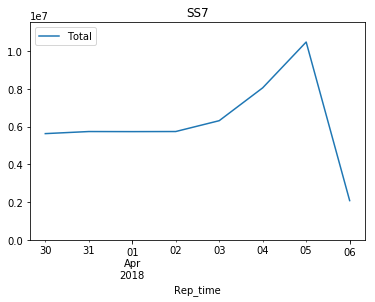

In [28]:
df_ss7.plot(x='Rep_time',y=['Total'],ylim=[0,max(df_ss7['Total'])*1.1])
plt.title('SS7')
plt.show()

# Splunk

In [1]:
from time import sleep
import sys
import splunklib.client as client

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime

In [2]:
log_level = 0

def outLog(message, level=1):
    if(level <= log_level):
        print (message)
        sys.stdout.flush()

### Подключение к Splunk

In [3]:
#HOST = "localhost"
HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)
# Print installed apps to the console to verify login
for app in service.apps:
    print app.name

alert_logevent
alert_webhook
appsbrowser
framework
gettingstarted
introspection_generator_addon
launcher
learned
legacy
lookup_editor
sample_app
search
simple_xml_examples
splunk_app_db_connect
splunk_archiver
splunk_datasets_addon
splunk_httpinput
splunk_instrumentation
splunk_monitoring_console
SplunkForwarder
SplunkLightForwarder


### Использование сохраненного запроса и конструкции
job = mysavedsearch.dispatch()

jobresults = job.results()

jobresults.read(1024)

In [19]:
#Посмотреть сохраненные запросы

#List the saved searches that are available to the current user
savedsearches = service.saved_searches
for savedsearch in savedsearches:
    if savedsearch.name.find('Test')!=-1:
        print "Search name: '" + savedsearch.name + "'" #Print search name
        print "Query:\n" + savedsearch["search"] + "\n" #Print query of the search

Search name: 'Test Search'
Query:
index=sdr | head 1



In [39]:
#Создать запрос

# Delete the test search
service.saved_searches.delete("Test Search")
# Create a saved search--search everything, return 1st 10 events
# Note: Do not include the 'search' keyword for a saved search
#myquery = "index=sdr | head 1"
myquery = 'index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 1 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT'
mysearchname = "Test Search"
mysavedsearch = service.saved_searches.create(mysearchname, myquery)
print "Created Search name: '" + mysavedsearch.name + "'"
print "Query:\n" + mysavedsearch["search"]

Created Search name: 'Test Search'
Query:
index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 1 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT


In [59]:
# Retrieve the result with saved search

mysavedsearch = service.saved_searches["Test Search"]

# Run the saved search
job = mysavedsearch.dispatch()
# Create a small delay to allow time for the update between server and client
sleep(2)
# Wait for the job to finish--poll for completion and display stats
while True:
    job.refresh()
    stats = {"isDone": job["isDone"],
             "doneProgress": float(job["doneProgress"])*100,
              "scanCount": int(job["scanCount"]),
              "eventCount": int(job["eventCount"]),
              "resultCount": int(job["resultCount"])}
    status = ("\r%(doneProgress)03.1f%%   %(scanCount)d scanned   "
              "%(eventCount)d matched   %(resultCount)d results") % stats
    sys.stdout.write(status)
    sys.stdout.flush()
    if stats["isDone"] == "1":
        break
    sleep(2)
# Display the search results now that the job is done
jobresults = job.results()
while True:
    content = jobresults.read(1024)
    if len(content) == 0: break
    sys.stdout.write(content)
    sys.stdout.flush()
sys.stdout.write("\n")

100.0%   101 scanned   1 matched   1 results<?xml version='1.0' encoding='UTF-8'?>
<results preview='0'>
<meta>
<fieldOrder>
<field>_time</field>
<field>IN_IMSI</field>
<field>OPCODE</field>
<field>O_GT</field>
<field>D_GT</field>
<field>RESULT</field>
</fieldOrder>
</meta>
	<result offset='0'>
		<field k='_time'>
			<value><text>2018-04-06T08:13:16.000+02:00</text></value>
		</field>
		<field k='IN_IMSI'>
			<value><text>425191201079122</text></value>
		</field>
		<field k='OPCODE'>
			<value><text>2</text></value>
		</field>
		<field k='O_GT'>
			<value><text>972559900040</text></value>
		</field>
		<field k='D_GT'>
			<value><text>972559912010791</text></value>
		</field>
		<field k='RESULT'>
			<value><text>ok</text></value>
		</field>
	</result>
</results>


### Выгрузка в DF с использованием .ResultsReader

In [ ]:
import splunklib
import splunklib.client as client
import splunklib.results as results

In [68]:
#Простеейшая конструкция для примера

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

dateFrom = datetime.datetime.strptime('2018-01-12T05:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = datetime.datetime.strptime('2018-01-12T12:00:00', '%Y-%m-%dT%H:%M:%S')

kwargs_export = {"earliest_time": FormatSplunkEngineDate(dateFrom),
                "latest_time":FormatSplunkEngineDate(dateTo) ,
                "search_mode": "normal",
                #"output_mode":"JSON",
                #"rf" : fields,
                "supports_multivalues":True
                }
searchquery_export = 'search index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 3 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT'
exportsearch_results = service.jobs.export(searchquery_export, **kwargs_export)
reader = results.ResultsReader(exportsearch_results)
for result in reader:
    print result

DEBUG: Configuration initialization for /opt/splunk/etc took 17ms when dispatching a search (search ID: 1522995770.2970444)
DEBUG: base lispy: [ AND 2 index::sdr map stp ]
DEBUG: search context: user="pavel", app="search", bs-pathname="/opt/splunk/etc"
WARN: Unable to distribute to peer named 172.19.11.50:8089 at uri=172.19.11.50:8089 using the uri-scheme=https because peer has status="Down".  Please verify uri-scheme, connectivity to the search peer, that the search peer is up, and an adequate level of system resources are available. See the Troubleshooting Manual for more information.
OrderedDict([('_time', '2018-01-12 11:59:59.000 CET'), ('IN_IMSI', '425019612056086'), ('OPCODE', '2'), ('O_GT', '393205981000'), ('D_GT', '972549612056086'), ('RESULT', 'ok')])
OrderedDict([('_time', '2018-01-12 11:59:59.000 CET'), ('IN_IMSI', '425019610393162'), ('OPCODE', '2'), ('O_GT', '886935420431'), ('D_GT', '972549610393162'), ('RESULT', 'T_Error')])
OrderedDict([('_time', '2018-01-12 11:59:59.0

In [69]:
#Пример выгрузки

#Создаем необходимые процедуры

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

def LoadSplunkResult(exportsearch_results):
        outputResult = list()
        
        i=0
    # Get the results and store them
        reader = results.ResultsReader(exportsearch_results)
        for result in reader:   
            if isinstance(result, dict):
                outputResult.append(result)
                i+=1
                if i%100==0: outLog("loaded {} records from splunk".format(i),0)
            elif isinstance(result, results.Message):
                # Diagnostic messages may be returned in the results
                outLog("Message: %s" % result)
        outLog("Splunk search found {} messages".format(len(outputResult)),0)
        return outputResult

def getSplunkFileResult(service, dateFrom, dateTo, searchquery_export, fileMask=None,protocol=None, bEchoTime = False):
    # Run an export search and display the results using the results reader.
    # Set the parameters for the search:
    sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
    sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
    kwargs_export = {"earliest_time": sfrom,
                     "latest_time":sto ,
                     "search_mode": "normal",
                     #"output_mode":"JSON",
                     #"rf" : fields,
                     "supports_multivalues":True
                     }

    #searchquery_export = 'search index=pcap protocol={} {} | extract mv_add=true , pairdelim="\\t;", kvdelim="=" | stats  min(frame_time_epoch) as minTime max(frame_time_epoch) as maxTime  by file '.format(protocol,fileMask)
    #searchquery_export = 'search index=sdr | head 1'
    #searchquery_export = 'search index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 3 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT'
    outLog("Run Splunk file search by query {}".format(searchquery_export),0)

    exportsearch_results = service.jobs.export(searchquery_export, **kwargs_export)

    return LoadSplunkResult(exportsearch_results)

In [79]:
#Указываем время, запрос и запускаем запрос

dateFrom = datetime.datetime.strptime('2018-01-12T05:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = datetime.datetime.strptime('2018-01-12T12:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 15 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT
'''
#searchquery_export = 'search index=sdr | head 1'

SplunkFileResult = getSplunkFileResult(service, dateFrom, dateTo, searchquery_export, fileMask=None,protocol=None, bEchoTime = False)

Run Splunk file search by query 
search index=sdr PROTOCOL=MAP OPCODE=2 SERVICE="stp" | head 15 | table _time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT

Splunk search found 15 messages


In [81]:
#Выгружаем результат в DataFrame
df=DataFrame(SplunkFileResult)
df.head()

,_time,IN_IMSI,OPCODE,O_GT,D_GT,RESULT
0,2018-01-12 11:59:59.000 CET,425019612056086,2,393205981000,972549612056086,ok
1,2018-01-12 11:59:59.000 CET,425019610393162,2,886935420431,972549610393162,T_Error
2,2018-01-12 11:59:59.000 CET,425019629501277,2,3584097020,972549629501277,ok
3,2018-01-12 11:59:59.000 CET,260060140000621,2,14047259687,487900140000621,ok
4,2018-01-12 11:59:59.000 CET,425019610603034,2,33660001066,972549610603034,ok


В приведенном выше варианте не выгрвжаются все данные. Много строк с нулями если делать длительный агрегированный запрос

In [3]:
## Исправленный вариант на основе:
#http://docs.splunk.com/DocumentationStatic/PythonSDK/1.6.3/client.html#splunklib.client.Job.results
#Ждет завершения выгрузки.

# !!!Работает с Python 2 и Python 3 !!!

import splunklib.client as client
import splunklib.results as results
from time import sleep

from pandas import Series, DataFrame
import datetime as dt

HOST = "splunk-search01.roamability.com"
PORT = 8089
USERNAME = "pavel"
PASSWORD = "O777ver7k1"
# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

#Указываем время, запрос и запускаем запрос

dateFrom = dt.datetime.strptime('2018-04-12T08:00:00', '%Y-%m-%dT%H:%M:%S')
dateTo = dt.datetime.strptime('2018-04-13T08:00:00', '%Y-%m-%dT%H:%M:%S')
searchquery_export =\
'''
search index=sdr (4250196* OR 26006*) PROTOCOL=S6a ANS_RES_CODE=2001
| eval CODE_TEMP=case(isnotnull(ANS_RES_CODE),ANS_RES_CODE,isnull(ANS_RES_CODE), ANS_EXP_RES_CODE, isnull(ANS_EXP_RES_CODE), EXP_RES_CODE, isnull(EXP_RES_CODE), RES_CODE)
| eval CODE=if(isnotnull(CODE_TEMP), CODE_TEMP, "PUR_NOR") | eval CUSTOMER=coalesce(THIRD_PARTY,MVNO)
| Timechart span=15m count by CUSTOMER  | table *
'''

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")
bEchoTime = False

sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
kwargs_export = {"earliest_time": sfrom,
                 "latest_time":sto ,
                 "search_mode": "normal",
                 #"output_mode":"JSON",
                 #"rf" : fields,
                 "supports_multivalues":True
                 }

job = service.jobs.create(searchquery_export, **kwargs_export)
while not job.is_done():
    sleep(.2)
rr = results.ResultsReader(job.results())

outputResult = list()
i=0

for result in rr:
            if isinstance(result, dict):
                outputResult.append(result)
assert rr.is_preview == False

df=DataFrame(outputResult)
df.tail()

,C9,MB,Mondicon,NAKA,OTHER,PuertoSeguro,Rewicom,Roamability,Telzar,TinkLab,Tinklabs,_span,_time
91,636,405,144,1566,0,14,0,170,2135,0,558,900,2018-04-13T06:45:00.000+02:00
92,842,458,160,1626,0,3,1,167,2238,4,3643,900,2018-04-13T07:00:00.000+02:00
93,803,272,151,1728,0,9,1,164,2247,0,745,900,2018-04-13T07:15:00.000+02:00
94,851,408,147,1841,0,13,0,168,2241,0,468,900,2018-04-13T07:30:00.000+02:00
95,931,463,123,1842,0,27,0,171,2347,0,226,900,2018-04-13T07:45:00.000+02:00


## Testing

In [68]:
import splunklib
import splunklib.client as client
import splunklib.results as results

def FormatSplunkEngineDate(dt): return dt.strftime("%Y-%m-%dT%H:%M:%S")

def LoadSplunkResult(exportsearch_results):
        outputResult = list()
        i=0
    # Get the results and store them
        reader = results.ResultsReader(exportsearch_results)
        for result in reader:   
            if isinstance(result, dict):
                outputResult.append(result)
                i+=1
                if i%100==0: outLog("loaded {} records from splunk".format(i),0)
            elif isinstance(result, results.Message):
                # Diagnostic messages may be returned in the results
                outLog("Message: %s" % result)
        outLog("Splunk search found {} messages".format(len(outputResult)),0)
        return outputResult

def getSplunkFileResult(service, dateFrom, dateTo,fileMask=None,protocol=None, bEchoTime = False):
    # Run an export search and display the results using the results reader.
    # Set the parameters for the search:
    sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
    sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
    kwargs_export = {"earliest_time": sfrom,
                     "latest_time":sto ,
                     "search_mode": "normal",
                     #,"output_mode":"JSON"
                     #"rf" : fields,
                     "supports_multivalues":True
                     }

    #searchquery_export = 'search index=pcap protocol={} {} | extract mv_add=true , pairdelim="\\t;", kvdelim="=" | stats  min(frame_time_epoch) as minTime max(frame_time_epoch) as maxTime  by file '.format(protocol,fileMask)
    #searchquery_export = 'search index=sdr | head 1'
    searchquery_export = 'search index=sdr PROTOCOL=MAP IN_IMSI=425019611031032 OPCODE=56 | head 1'
    outLog("Run Splunk file search by query {}".format(searchquery_export),0)

    exportsearch_results = service.jobs.export(searchquery_export, **kwargs_export)

    return LoadSplunkResult(exportsearch_results)

def getSplunkSearchResult(service, dateFrom, dateTo, searchQuery,fileMask=None,protocol=None,fields=None, bEchoTime = False):
    # Run an export search and display the results using the results reader.
    # Set the parameters for the search:
    sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
    sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
    kwargs_export = {"earliest_time": sfrom,
                     "latest_time":sto ,
                     "search_mode": "normal",
                     #,"output_mode":"JSON"
                     "rf" : fields,
                     "supports_multivalues":True
                     }
    fieldsStr = ','.join(fields)
    
    #searchquery_export = 'search index=pcap protocol={} {} {} | extract mv_add=true , pairdelim="\\t;", kvdelim="=" |  fields {}'.format(protocol,fileMask,searchQuery,fieldsStr)
    searchquery_export = 'search index=sdr | head 1'
    outLog("Run Splunk search by query {}".format(searchquery_export))
    exportsearch_results = service.jobs.export(searchquery_export, **kwargs_export)

    return LoadSplunkResult(exportsearch_results)

def runSplunkSearch(filterObj,rangeObj,protocol,fileList,iterations,outputFolder):

    outLog("Run search by protocol " + protocol,0)
    outputSplunk = outputFolder +"/splunk."+ protocol + ".pcap"
    timeRange = GetTimeRange(protocol)

    service = client.connect(host='splunk.roamability.com', port=8089,username="admin", password='3dFrcWbJQ7Ap7AvemXifxgEP97VQHEHdKVU')
    splunkMask = GetFilterMask(filterObj,True,False,False)
    customMask = GetFilterMask(filterObj,False,False,True)
    if splunkMask=="" and customMask!="":
        outLog("Skip search splunk by protocol " + protocol + " due only custom filter set",0)
        return outputSplunk;
    fileMask = ""
    #add files to mask
    firstFile=True
    fileMask ="("
    for fname in fileList:
        if not fileList[fname]["enabled"]: continue
        if fileList[fname]["protocol"]!=protocol: continue
        if not firstFile: fileMask+=" OR "
        fileMask+="file={}".format(fileList[fname]["splunkmask"])
        firstFile = False
    fileMask+=")"
    if(firstFile): return outputSplunk


    #format like 2017-03-06T16:28
    dateFrom = datetime.datetime.strptime(rangeObj["From"], '%Y-%m-%dT%H:%M')
    dateTo = datetime.datetime.strptime(rangeObj["To"], '%Y-%m-%dT%H:%M')
    
    fields = ["file","frame_time_epoch"] + getProtocolFilterField(protocol)
    if splunkMask=="":
        splunkResult = getSplunkFileResult(service,dateFrom,dateTo,fileMask,protocol)
        if len(splunkResult) == 0:
            outLog('Empty file list after filtering. Exiting...'.format(protocol),0)
            return outputSplunk
        fileList = getFileListRange(splunkResult)
        outLog(fileList)
        mergeOutputPlain(outputSplunk,fileList,outputFolder,protocol)
    else:
        splunkResult = getSplunkSearchResult(service,dateFrom,dateTo,splunkMask,fileMask,protocol,fields)
        if len(splunkResult) == 0:
            outLog('Empty transactions list after filtering. Exiting...'.format(protocol),0)
            return outputSplunk
        #we get results, then we have to go by TIDS
        i = 0
    
        while i < iterations:
            tids = getTidsDict(splunkResult,protocol)
            outLog("{} messages ids found before {} iterations".format(len(tids),i + 1),0)

            #delta = datetime.timedelta(seconds=timeRange * (i + 1))
            delta = timeRange * (i + 1)
            if(len(tids) > 0):
                tidMask, dtFrom, dtTo = createTidMask(tids,protocol,timeRange,False)
                if tidMask=='': 
                    outLog('Empty {} transactions list after filtering. Exiting...'.format(protocol),0)
                    return outputSplunk

                splunkResult = getSplunkSearchResult(service,dtFrom - delta, dtTo + delta,tidMask,fileMask,protocol,fields,True)
                i+=1
            
            else:
                outLog('Empty {} transactions list after filtering. Exiting...'.format(protocol),0)
                return outputSplunk

        fileList = getFileList(splunkResult,protocol)

        outLog(fileList)
        mergeOutput(outputSplunk,fileList,outputFolder)
    return outputSplunk


In [69]:
dateFrom = datetime.datetime.strptime('2018-03-12T05:00', '%Y-%m-%dT%H:%M')
dateTo = datetime.datetime.strptime('2018-03-12T05:10', '%Y-%m-%dT%H:%M')

#sfrom = dateFrom if  bEchoTime else FormatSplunkEngineDate(dateFrom) 
#sto = dateTo if  bEchoTime else FormatSplunkEngineDate(dateTo)
sfrom = FormatSplunkEngineDate(dateFrom) 
sto = FormatSplunkEngineDate(dateTo)

res=getSplunkFileResult(service,dateFrom,dateTo)
res

Run Splunk file search by query search index=sdr PROTOCOL=MAP IN_IMSI=425019611031032 OPCODE=56 | head 1
Splunk search found 1 messages


[OrderedDict([('IN_IMSI', '425019611031032'),
              ('OPCODE', '56'),
              ('PROTOCOL', 'MAP'),
              ('_bkt', 'sdr~57~AB9CA7E0-957E-4F84-9840-0E7D97578CB1'),
              ('_cd', '57:22908727'),
              ('_indextime', '1520827729'),
              ('_kv', '1'),
              ('_raw',
               '12/03/2018 05:07:51.043;\t SERVICE="stp";\tSEP_RI="63";\tGW_REQUEST="1";\tORIGINATION_SEP="393";\tPROTOCOL="MAP";\tIN_IMSI="425019611031032";\tO_GT="8613441822";\tD_GT="972549611031032";\tO_SSN="7";\tD_SSN="6";\tOPCODE="56";\tACN="04000001000e03";\tPREFIX_FLAG="1";\tDESTINATION="multibyte";\tRESULT="ok";\tDURATION="0.290"'),
              ('_serial', '0'),
              ('_si', ['splunk-idx-01', 'sdr']),
              ('_sourcetype', 'sdr-logs'),
              ('_time', '2018-03-12 05:07:51.000 CET'),
              ('host', 'stp1'),
              ('index', 'sdr'),
              ('linecount', '1'),
              ('source', '/tmp/sdr/sdr_1520827729_63.txt'),
  

In [79]:
res[0]['IN_IMSI']

'425019611031032'